In [1]:
%load_ext autoreload
%autoreload 2

# Grupo Bimbo Inventory Demand 

**_DESCRIPTION_**:
Planning a celebration is a balancing act of preparing just enough food to go around without being stuck eating the same leftovers for the next week. The key is `anticipating how many guests will come`. Grupo Bimbo must weigh similar considerations as it strives to meet daily consumer demand for fresh bakery products on the shelves of over 1 million stores along its 45,000 routes across Mexico.

Currently, daily inventory calculations are performed by direct delivery sales employees who must single-handedly predict the forces of supply, demand, and hunger based on their personal experiences with each store. With some breads carrying a one week shelf life, the acceptable margin for error is small.

In this competition, Grupo Bimbo invites Kagglers to develop a `model to accurately forecast inventory demand based on historical sales data`. Doing so will make sure consumers of its over 100 bakery products aren’t staring at empty shelves, while also reducing the amount spent on refunds to store owners with surplus product unfit for sale.

**_EVALUATION_**:
The evaluation metric for this competition is `Root Mean Squared Logarithmic Error`.

The RMSLE is calculated as:

$$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$
Where:

ϵ is the RMSLE value (score)
n is the total number of observations in the (public/private) data set,
pi is your prediction of demand, and
ai is the actual demand for i.
log(x) is the natural logarithm of x
Submission File
For every row in the dataset, submission files should contain two columns: id and Demanda_uni_equi.  The id corresponds to the column of that id in the test.csv. The file should contain a header and have the following format:

**_DATA_**: https://www.kaggle.com/c/5260/download-all

### Load our libraries

In [2]:
# Data analysis and Wrangling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Operating System
import os

In [3]:
from bimbo.data import Bimbo

data = Bimbo().get_data()

In [4]:
for f in os.listdir('../data/csv/'):
    print(f.ljust(30) + str(round(os.path.getsize('../data/csv/' + f) / 1000000, 2)) + 'MB')

producto_tabla.csv            0.11MB
cliente_tabla.csv             21.25MB
test.csv                      251.11MB
town_state.csv                0.03MB
train.csv                     3199.36MB
sample_submission.csv         68.88MB


We have 6 datasets:

- train.csv — the training set
- test.csv — the test set
- sample_submission.csv — a sample submission file in the correct format
- cliente_tabla.csv — client names (can be joined with train/test on Cliente_ID)
- producto_tabla.csv — product names (can be joined with train/test on Producto_ID)
- town_state.csv — town and state (can be joined with train/test on Agencia_ID)

---------------------------

##### **Semana** — Week number (From Thursday to Wednesday)

**Agencia_ID** — Sales Depot ID

**Canal_ID** — Sales Channel ID

**Ruta_SAK** — Route ID (Several routes = Sales Depot)

**Cliente_ID** — Client ID

**NombreCliente** — Client name

**Producto_ID** — Product ID

**NombreProducto** — Product Name

**Venta_uni_hoy** — Sales unit this week (integer)

**Venta_hoy** — Sales this week (unit: pesos)

**Dev_uni_proxima** — Returns unit next week (integer)

**Dev_proxima** — Returns next week (unit: pesos)

**Demanda_uni_equil** — Adjusted Demand (integer) (This is the target you will predict)

### Feature Exploration, Engineering and Cleaning

In [5]:
# Load in the train and test datasets
train_df = pd.read_csv('../data/csv/train.csv')
test_df = pd.read_csv('../data/csv/test.csv')
cliente_tabla_df = pd.read_csv('../data/csv/cliente_tabla.csv')
producto_tabla_df = pd.read_csv('../data/csv/producto_tabla.csv')
town_state_df = pd.read_csv('../data/csv/town_state.csv')
sample_submission_df = pd.read_csv('../data/csv/sample_submission.csv')

In [6]:
# Demanda_uni_equil is the target value that we are trying to predict.
target = train_df['Demanda_uni_equil'].tolist()

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 11 columns):
Semana               int64
Agencia_ID           int64
Canal_ID             int64
Ruta_SAK             int64
Cliente_ID           int64
Producto_ID          int64
Venta_uni_hoy        int64
Venta_hoy            float64
Dev_uni_proxima      int64
Dev_proxima          float64
Demanda_uni_equil    int64
dtypes: float64(2), int64(9)
memory usage: 6.1 GB


In [8]:
train_df.nunique()

Semana                    7
Agencia_ID              552
Canal_ID                  9
Ruta_SAK               3603
Cliente_ID           880604
Producto_ID            1799
Venta_uni_hoy          2116
Venta_hoy             78140
Dev_uni_proxima         558
Dev_proxima           14707
Demanda_uni_equil      2091
dtype: int64

In [9]:
train_df.loc[train_df['Agencia_ID'] == 4086].count()

Semana               2710
Agencia_ID           2710
Canal_ID             2710
Ruta_SAK             2710
Cliente_ID           2710
Producto_ID          2710
Venta_uni_hoy        2710
Venta_hoy            2710
Dev_uni_proxima      2710
Dev_proxima          2710
Demanda_uni_equil    2710
dtype: int64

- **train**

In [10]:
train_df.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


In [11]:
train_df.describe()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
count,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07
mean,5.950021e+00,2.536509e+03,1.383181e+00,2.114855e+03,1.802119e+06,2.084081e+04,7.310163e+00,6.854452e+01,1.302577e-01,1.243248e+00,7.224564e+00
std,2.013175e+00,4.075124e+03,1.463266e+00,1.487744e+03,2.349577e+06,1.866392e+04,2.196734e+01,3.389795e+02,2.932320e+01,3.921552e+01,2.177119e+01
min,3.000000e+00,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,1.312000e+03,1.000000e+00,1.161000e+03,3.567670e+05,1.242000e+03,2.000000e+00,1.676000e+01,0.000000e+00,0.000000e+00,2.000000e+00
50%,6.000000e+00,1.613000e+03,1.000000e+00,1.286000e+03,1.193385e+06,3.054900e+04,3.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,3.000000e+00
75%,8.000000e+00,2.036000e+03,1.000000e+00,2.802000e+03,2.371091e+06,3.742600e+04,7.000000e+00,5.610000e+01,0.000000e+00,0.000000e+00,6.000000e+00
max,9.000000e+00,2.575900e+04,1.100000e+01,9.991000e+03,2.015152e+09,4.999700e+04,7.200000e+03,6.473600e+05,2.500000e+05,1.307600e+05,5.000000e+03


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 11 columns):
Semana               int64
Agencia_ID           int64
Canal_ID             int64
Ruta_SAK             int64
Cliente_ID           int64
Producto_ID          int64
Venta_uni_hoy        int64
Venta_hoy            float64
Dev_uni_proxima      int64
Dev_proxima          float64
Demanda_uni_equil    int64
dtypes: float64(2), int64(9)
memory usage: 6.1 GB


In [13]:
train_df.isnull().sum()

Semana               0
Agencia_ID           0
Canal_ID             0
Ruta_SAK             0
Cliente_ID           0
Producto_ID          0
Venta_uni_hoy        0
Venta_hoy            0
Dev_uni_proxima      0
Dev_proxima          0
Demanda_uni_equil    0
dtype: int64

In [14]:
train_df.isna().sum()

Semana               0
Agencia_ID           0
Canal_ID             0
Ruta_SAK             0
Cliente_ID           0
Producto_ID          0
Venta_uni_hoy        0
Venta_hoy            0
Dev_uni_proxima      0
Dev_proxima          0
Demanda_uni_equil    0
dtype: int64

Neither null nor missing values in the training dataset.

In [15]:
# Semana — Week number (From Thursday to Wednesday)
train_df.groupby('Semana')['Semana'].count()

Semana
3    11165207
4    11009593
5    10615397
6    10191837
7    10382849
8    10406868
9    10408713
Name: Semana, dtype: int64

They are all from week ('semana') three.
Nevether, this is because it is a small portion of the dataset.
If we take a bigger one, we should have three to 9.
Therefore, this is likely a time series prediction problem.

In [16]:
# Agencia_ID — Sales Depot ID
train_df.groupby('Agencia_ID')['Agencia_ID'].count()

Agencia_ID
1110      55275
1111     449195
1112     354849
1113     204224
1114      48028
1116     489201
1117     554123
1118     360057
1119     413610
1120     466687
1121     540453
1122     458303
1123     729103
1124     399513
1126     576979
1127     399767
1129      49650
1130     465188
1137     447418
1138     354748
1139      43591
1140     420232
1142      50213
1143      47510
1146      58246
1147      24879
1150     111980
1152      68035
1153     452949
1155      27765
          ...  
4051     434312
4061      34406
4062      25941
4063      18714
4064      17777
4066       9407
4078       4069
4079       4686
4081       2646
4082       3825
4084       1295
4085       1443
4086       2710
4087       2858
4089       1318
4091       1169
22090    290404
22187    304101
22362    356093
22414    145816
22560    392605
23669    166762
23719    171215
23879     49005
23899    184070
24049    106285
24539     95434
24669    133394
25699     71396
25759    214801
Name: Agencia

In [17]:
# Canal_ID — Sales Channel ID
train_df.groupby('Canal_ID')['Canal_ID'].count()

Canal_ID
1     67435217
2       839496
4      3757773
5       145818
6       281389
7       671128
8        66970
9          378
11      982295
Name: Canal_ID, dtype: int64

In [18]:
# Ruta_SAK — Route ID (Several routes = Sales Depot)
train_df.groupby('Ruta_SAK')['Ruta_SAK'].count().head()

Ruta_SAK
1    2461
2    1441
3    2195
4    1690
5     803
Name: Ruta_SAK, dtype: int64

In [19]:
# Cliente_ID — Client ID
train_df.groupby('Cliente_ID')['Cliente_ID'].count().head()

Cliente_ID
26     227
60     248
65     630
101     15
105    345
Name: Cliente_ID, dtype: int64

In [20]:
# Venta_uni_hoy — Sales unit this week (integer)
train_df.groupby('Venta_uni_hoy')['Venta_uni_hoy'].count().head(10)

Venta_uni_hoy
0      302559
1    13496679
2    15299482
3     9271143
4     7260737
5     5707842
6     4272687
7     1762233
8     2423855
9     1191273
Name: Venta_uni_hoy, dtype: int64

In [21]:
# Venta_hoy — Sales this week (unit: pesos)
train_df.groupby('Venta_hoy')['Venta_hoy'].count().head(10)

Venta_hoy
0.00    302559
0.04         1
0.26         2
0.41         1
0.50        75
0.53         7
0.69         1
0.75      1782
0.77      3228
0.78         3
Name: Venta_hoy, dtype: int64

In [22]:
# Dev_uni_proxima — Returns unit next week (integer)
train_df.groupby('Dev_uni_proxima')['Dev_uni_proxima'].count().head(10)

Dev_uni_proxima
0    71636003
1     1268616
2      514304
3      220620
4      128609
5       96406
6       60086
7       30359
8       32112
9       19782
Name: Dev_uni_proxima, dtype: int64

In [23]:
# Dev_proxima — Returns next week (unit: pesos)
train_df.groupby('Dev_proxima')['Dev_proxima'].count().head(10)

Dev_proxima
0.00    71636003
0.03           1
0.50           2
0.75          92
0.77         266
0.87           1
1.23           4
1.35           4
1.50          59
1.54         187
Name: Dev_proxima, dtype: int64

In [24]:
# Demanda_uni_equil — Adjusted Demand (integer) (This is the target you will predict)
train_df.groupby('Demanda_uni_equil')['Demanda_uni_equil'].count().head(10)

Demanda_uni_equil
0     1336821
1    13249749
2    14997665
3     9150147
4     7176357
5     5634148
6     4220142
7     1756403
8     2401131
9     1192219
Name: Demanda_uni_equil, dtype: int64

-------------------------------

Which features are **categorical**?

- Categorical: Week Number.

Which features are **numeric**?

- Continous: Sales this week, Returns next week. Discrete: Sales unit this week, Returns unit next week.

-------------------------------

- **test**

In [25]:
test_df.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


In [26]:
test_df.describe()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
count,6.999251e+06,6.999251e+06,6.999251e+06,6.999251e+06,6.999251e+06,6.999251e+06,6.999251e+06
mean,3.499625e+06,1.049446e+01,2.504463e+03,1.401874e+00,2.138014e+03,1.819128e+06,2.216307e+04
std,2.020510e+06,4.999694e-01,4.010228e+03,1.513404e+00,1.500392e+03,2.938910e+06,1.869816e+04
min,0.000000e+00,1.000000e+01,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01
25%,1.749812e+06,1.000000e+01,1.311000e+03,1.000000e+00,1.159000e+03,3.558290e+05,1.242000e+03
50%,3.499625e+06,1.000000e+01,1.612000e+03,1.000000e+00,1.305000e+03,1.200109e+06,3.150700e+04
75%,5.249438e+06,1.100000e+01,2.034000e+03,1.000000e+00,2.804000e+03,2.387881e+06,4.093000e+04
max,6.999250e+06,1.100000e+01,2.575900e+04,1.100000e+01,9.950000e+03,2.015152e+09,4.999700e+04


In [27]:
test_df.groupby('Semana')['Semana'].count()

Semana
10    3538385
11    3460866
Name: Semana, dtype: int64

In [28]:
test_df.groupby('Agencia_ID')['Agencia_ID'].count()

Agencia_ID
1110      5261
1111     41787
1112     33171
1113     20715
1114      4445
1116     50711
1117     51409
1118     32995
1119     38643
1120     43709
1121     52003
1122     42589
1123     64833
1124     43806
1126     53511
1127     38575
1129      4624
1130     44329
1137     41460
1138     32470
1139      4257
1140     46833
1142      4657
1143      5067
1146      5931
1147      2492
1150     10986
1152      6449
1153     50147
1155      2886
         ...  
4051     43203
4061      3251
4062      2549
4063      1785
4064      1644
4066       830
4078       400
4079       410
4081       270
4082       372
4084       129
4085       140
4086       233
4087       257
4089       125
4091       118
22090    31355
22187    27042
22362    32554
22414    13871
22560    23924
23669    15530
23719    17745
23879     4479
23899    16336
24049     9960
24539     8666
24669    12711
25699     6741
25759    22234
Name: Agencia_ID, Length: 552, dtype: int64

### Visualisations

In [29]:
def label_plot(title, x, y):
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)

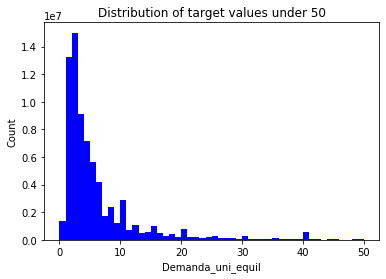

In [30]:
plt.hist(target, bins=50, color='blue', range=(0, 50))
label_plot('Distribution of target values under 50', 'Demanda_uni_equil', 'Count')
plt.show()

(0, 50)

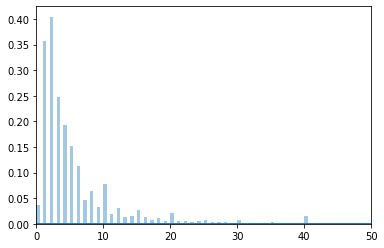

In [31]:
plt.clf()
sns.distplot(target, bins=10000)
plt.xlim(0, 50)

In [32]:
from collections import Counter
print(Counter(target).most_common(10))

[(2, 14997665), (1, 13249749), (3, 9150147), (4, 7176357), (5, 5634148), (6, 4220142), (10, 2886205), (8, 2401131), (7, 1756403), (0, 1336821)]


### Baseline

In [ ]:
train_df'Demanda_uni_equil'

In [46]:
train_df['mean_demanda_uni_equil'] = train_df.pivot_table('Demanda_uni_equil', \
                                    ['Producto_ID', 'Agencia_ID'], aggfunc='mean').reset_index()

In [48]:
train_df.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,mean_demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,41.0
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,41.0
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,41.0
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,41.0
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,53.0


In [36]:
sample_submission_df.count()

id                   6999251
Demanda_uni_equil    6999251
dtype: int64

In [37]:
test_df.count()

id             6999251
Semana         6999251
Agencia_ID     6999251
Canal_ID       6999251
Ruta_SAK       6999251
Cliente_ID     6999251
Producto_ID    6999251
dtype: int64

In [ ]:
def create_dumb_pred(df):
    

In [ ]:
test_df[''] = test_df.apply(lambda x: x * 2)

In [33]:
# # Considering the fact that the most common value we found is 2, we can submit 2 as a baseline.

# sample_submission_df['Demanda_uni_equil'] = 2
# sample_submission_df.to_csv('mostcommon.csv', index=False)

In [34]:
# sample_submission_df.describe

<bound method NDFrame.describe of               id  Demanda_uni_equil
0              0                  2
1              1                  2
2              2                  2
3              3                  2
4              4                  2
5              5                  2
6              6                  2
7              7                  2
8              8                  2
9              9                  2
10            10                  2
11            11                  2
12            12                  2
13            13                  2
14            14                  2
15            15                  2
16            16                  2
17            17                  2
18            18                  2
19            19                  2
20            20                  2
21            21                  2
22            22                  2
23            23                  2
24            24                  2
25            25              

In [35]:
# most_common_df = pd.read_csv('../notesbooks/mostcommon.csv')

FileNotFoundError: [Errno 2] File b'../notesbooks/mostcommon.csv' does not exist: b'../notesbooks/mostcommon.csv'

In [ ]:
# most_common_df.head()

### Using Facebook's Prophet

In [ ]:
# from fbprophet import Prophet

In [ ]:
# df_prophet = train_df[['Semana', 'Demanda_uni_equil']]
# df_prophet = df_prophet.rename(columns={"Semana": "ds", "Demanda_uni_equil": "y"})

The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp

In [ ]:
# m = Prophet()
# m.fit(df_prophet)

In [ ]:
# future = m.make_future_dataframe(periods=2)
# future.tail()

In [ ]:
# forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# fig1 = m.plot(forecast)

In [ ]:
# fig2 = m.plot_components(forecast)

In [ ]:
# from fbprophet.plot import plot_plotly
# import plotly.offline as py
# py.init_notebook_mode()

# fig = plot_plotly(m, forecast)  # This returns a plotly Figure
# py.iplot(fig)

### Exploration

In [ ]:
test_df.head(3)

In [ ]:
train_df_exp = train_df.loc[
              (train_df['Agencia_ID'] == 4086)
            & (train_df['Canal_ID'] == 5)
#             & (train_df['Ruta_SAK'] == 3001)
            & (train_df['Cliente_ID'] == 653378)
            & (train_df['Producto_ID'] == 2261)
            ]
train_df_exp

In [ ]:
plt.scatter(train_df_exp['Semana'], train_df_exp['Demanda_uni_equil'])

-----------------------

In [ ]:
test_df_exp = test_df.loc[
              (test_df['Agencia_ID'] == 4086)
            & (test_df['Canal_ID'] == 5)
            & (test_df['Ruta_SAK'] == 3001)
            & (test_df['Cliente_ID'] == 653378)
            & (test_df['Producto_ID'] == 2261)
            ]
test_df_exp

In [ ]:
producto_tabla_df.head()

### Baseline #1